In [1]:
# start by loading data on the returns of the market portfolio and the risk-free rate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# Value Investing

One of the most popular quantitative investing strategies is broadly refered to as "value investing"

* It consists of tilting the portfolio towards stocks that have a low price relative to a proxy for it's fundamental value

* and tilt away form stocks with high price relative to fundamentals

* Broadly speaking: Buy cheap, sell expensive

* weights: 

$$W_t \propto \frac{F_t}{P_t}$$

* Where $F_t$ is some proxy for the firm's fundamental value

* typically some accounting measure

* There is a vast number of proxys for fundamentals

  * Dividends
  * Book value
  * Earnings
  * Cash flows
  * Sales

* The strategy is the "cross-sectional" counterpart of market timing strategies that rely on dividend yield of aggregate market as a proxy for whether the market is expensive.

* However, the evidence is that cross-sectional strategy is more reliable, even if it still quite risky. It actually has done terribly in the last 10 years!


**Why this might work?**

* Lots of theories that attempt to explain the value-growth spread, both "rational" and "behavioral"

* Here is a flavor of a few of these theories
   
    - Behavioral: Growth firms are firms in "sexy" sectors with tons of media/investor attention, Value are boring/old firms that no one wants to talk about. The end resul is that these sexy firms end up with extreme expensive valuations and the boring firms with very cheap valautions ()[paper]
    - Rational: Value firms are riskier than growth because the tend to do poorly in recessions (for example value did terribly in 2008 and 2020) ()[paper]
    
    
    
* Overall most academics think there is a behavioral component in value, but quite a bit has to do with more rational factors, i.e. value is riskier than growth in a variety of ways
 

**Construction**

* In these notes we will get the "value signal" ready and focus on building our portfolios

* In the subsection "Value Signal Construction" we show one way to construct the "Book-To-Market" value signal from the ground up




In [70]:
url = "https://www.dropbox.com/s/lyvzy649na6p8su/value_characteristic.csv?dl=1"
parser = lambda date: pd.to_datetime(date,format='%m%y')
Data = pd.read_csv(url,parse_dates=[0])
# This simply shits the date to be in an end of month basis
Data.date=Data.date+pd.tseries.offsets.MonthEnd()
Data.rename(columns={'size':'log_mcap'},inplace=True)
Data

,date,permno,re,rf,log_mcap,value
0,1972-07-31,10006,0.028600,0.0031,12.399869,-0.125361
1,1972-07-31,10102,0.039757,0.0031,12.217334,0.354954
2,1972-07-31,10137,-0.044767,0.0031,13.069874,-0.088697
3,1972-07-31,10145,-0.062422,0.0031,13.608366,0.075484
4,1972-07-31,10153,-0.065600,0.0031,11.752572,0.944457
...,...,...,...,...,...,...
486422,2016-12-31,93420,0.011056,0.0003,14.337515,1.049163
486423,2016-12-31,93422,-0.063881,0.0003,15.256946,0.829353
486424,2016-12-31,93423,0.039950,0.0003,15.502888,-2.128977
486425,2016-12-31,93429,0.072124,0.0003,15.504722,-3.001095


- above we load a data set with our value signal, Book-to-Market already constructed. Here is the definition of the value variable:
     
     >Value (annual) (value). Follows Fama and French (1993). value = log(BE/ME). At the end of June of each year, we use book equity from the previous fiscal year and market equity from December of the previous year. Rebalanced annually. 

- The data set also containts a size variable:

   > Size (size). Follows Fama and French (1993). size = MEJun. The CRSP end of June price times shares outstanding. Rebalanced annually.
   
   **I believe this is in logs as well. Need to check**
   
And contains excess returns (re) for individual stocks and the risk-free rate  of the relvant date

- permno is an identifier for the stock

- Note the format of the data set where stock and dates are stacked vertically

- We will need two indexes (date and permno) to perfectly identify an observation


**->This means we will start with step 1 already done for us (signal construction), and we will move directly to step 2**

**Details on how the value signal was constructed**

* Value portfolios are typically rebalanced every July using Book-to-Market data from the year before    
* This means that from July/2006 to June/2007 you use Book-to-Market data from December/2005
* Because the way we construct the data, the BM data is the same from Jan/2005 to December/2005

**What is important is that it is lagged by at least 12 months, to make sure that the BM data was available at the day of portfolio formation!**

**What does the value signal look like?**

<AxesSubplot:>

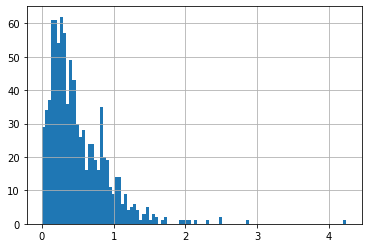

In [3]:
# lets look at what out value measure looks like for a particular date:
np.exp(Data[Data.date=='2016-12-31'].value).hist(bins=100)


- A lot of cross-section variation across firms

- some firms have very low book-to-market: accounting value low relative to market value

- Other firms have high book to market: accounting value high relative to market value

<AxesSubplot:xlabel='date'>

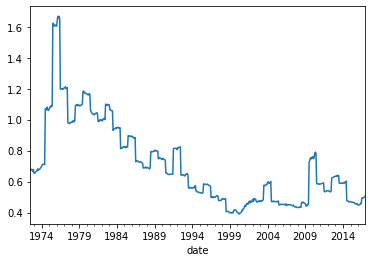

In [4]:
# lets look overtime
Data.groupby(by='date').value.apply(lambda x: np.exp(x).mean()).plot()

* a lot of time-variation in it

  * everything tends to be value at the same time 
  
* instead of time-variation, strategy that we want to construct want to explore variation across stocks

* lets look at how the signal dispersion changed



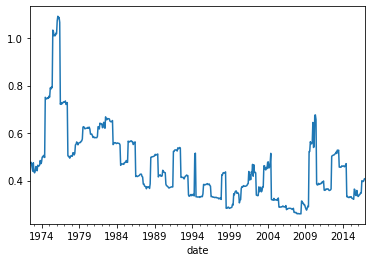

In [8]:
Data.groupby(by='date').value.apply(lambda x: np.exp(x).std()).plot()

**Quantitative investing is all about ranking**

* [$\checkmark$] Get returns for each asset

* [$\checkmark$] Construct the signals for each asset

- \[X\]  Rank the signals in each date

- \[X\]  Choose how many assets to pool together. Trade-off between signal strength and diversification

     * If you only buy the highest signal asset, you lose diversification

**How to rank?**


- We will assign the stocks in to quantiles according to it's relative characteristic position in the particular date

In [72]:
df=Data.copy()

We now do both the ranking and grouping in one single command

* Here we use `qdcut` to split the portfolios by Book-to-Market into 10 quantiles

  (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.qcut.html)
  
* The key here is to use the groupby operation to group things by date and do the quantile grouping in each date

* For each date, Pandas ranks portfolios and labels the lowest portfolio $0$

* Because Pandas ranking starts at 0, we add 1 so our portfolio ranks are from 1 to 5

In [7]:
df[df.date=='1972-07-31'].sort_values(by='value').head(5)

,date,permno,re,rf,size,value
678,1972-07-31,42753,-0.191779,0.0031,11.485841,-3.347548
560,1972-07-31,34649,-0.450313,0.0031,12.852010,-3.321926
767,1972-07-31,47335,0.059757,0.0031,13.506375,-2.901124
631,1972-07-31,40416,0.040664,0.0031,15.698746,-2.885152
541,1972-07-31,31659,0.060031,0.0031,12.844695,-2.804002


In [8]:
df[df.date=='1972-07-31'].sort_values(by='value').tail(5)

,date,permno,re,rf,size,value
4,1972-07-31,10153,-0.065600,0.0031,11.752572,0.944457
28,1972-07-31,11092,-0.039464,0.0031,11.664380,1.081444
93,1972-07-31,14189,0.025636,0.0031,12.770898,1.191488
455,1972-07-31,26569,-0.094009,0.0031,11.498644,1.347299
416,1972-07-31,25507,-0.112011,0.0031,11.410826,1.561624


In [73]:
ngroups=10
df['value_group']=df.groupby(['date'])['value'].transform(lambda x: pd.qcut(x, ngroups, labels=False,duplicates='drop'))
df

,date,permno,re,rf,log_mcap,value,value_group
0,1972-07-31,10006,0.028600,0.0031,12.399869,-0.125361,7
1,1972-07-31,10102,0.039757,0.0031,12.217334,0.354954,9
2,1972-07-31,10137,-0.044767,0.0031,13.069874,-0.088697,7
3,1972-07-31,10145,-0.062422,0.0031,13.608366,0.075484,8
4,1972-07-31,10153,-0.065600,0.0031,11.752572,0.944457,9
...,...,...,...,...,...,...,...
486422,2016-12-31,93420,0.011056,0.0003,14.337515,1.049163,9
486423,2016-12-31,93422,-0.063881,0.0003,15.256946,0.829353,9
486424,2016-12-31,93423,0.039950,0.0003,15.502888,-2.128977,1
486425,2016-12-31,93429,0.072124,0.0003,15.504722,-3.001095,0


**From signals to weights: Portfolio formation tradeoffs**

* We will start by constructing Equal weighted portfolios within each signal bucket

* Why not sort in 100 groups instead on only 10? This way your top value would be much more value

* Why no simply focus on the highest value stock?


  1. Individual stocks have $\sigma$ = 40 − 80%, so $\sigma/\sqrt{T}$ makes it nearly impossible to accurately measure E(R). Portfolios have lower $\sigma$ by diversification.
  2. So if you have to trade-off strengh of the signal against benefits of diversification

**Calculate the portfolio return**

We will do market cap weights, but you could do Equal weight or even sginal weights

$$\sum_i^I w_{it} r_{it}$$

Where the weights must add up to 1.

In [87]:
value_mktcapweighted =df.groupby(['date','value_group']).apply(lambda x:(x.re*np.exp(x.log_mcap)).sum()/np.exp(x.log_mcap).sum())
value_mktcapweighted=value_mktcapweighted.unstack(level=-1)
value_mktcapweighted.tail(5)

value_group,0,1,2,3,4,5,6,7,8,9
date,,,,,,,,,,
2016-08-31,-0.008146,-0.018026,0.013913,0.000831,-0.005915,0.002180,0.012825,0.004144,0.007465,0.032755
2016-09-30,0.004864,-0.007485,-0.007687,0.010992,-0.000877,0.006886,-0.027498,0.007407,0.006084,0.008546
2016-10-31,-0.027080,-0.027432,-0.015324,-0.015828,-0.024748,-0.023871,0.002012,-0.022012,-0.000566,0.002411
2016-11-30,0.030611,0.018022,-0.002154,0.032235,0.048093,0.026520,0.094515,0.060076,0.091699,0.098315
2016-12-31,0.005570,0.009199,0.018899,0.018558,0.007404,0.007571,0.027476,0.022341,0.057782,0.030229


<AxesSubplot:xlabel='value_group'>

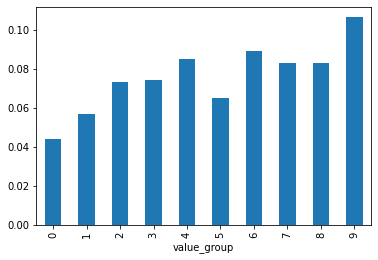

In [88]:
(value_mktcapweighted.mean()*12).plot.bar()

* It is important when constructing any weights that the weights you are using are a function only of variables known before the time of the trade.

* Here in this case we are using the size variable which is the market cap of the firm last december as explained above

* what is important is that this info is tradable, ideally we would use more recent market caps, but market caps are very persistent, so the result will be similar

* If you didn't lag what would it be the problem? That is suppose that you use market cap from the end of the trading month? What bias would that introduce? Would this be a valid strategy?



<AxesSubplot:xlabel='date'>

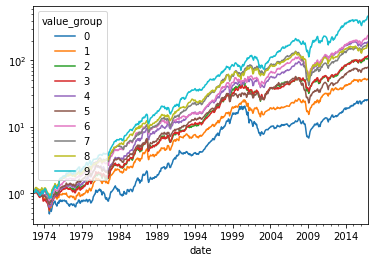

In [96]:
# recall that these portfolio are all excree returns becasue re was an excess return, 
# so we need to add back the risk-free rate to see the returns over time
rf=df.groupby(by='date').rf.mean()
(value_mktcapweighted.add(rf,axis='rows')+1).cumprod().plot(logy=True)

**What do you see here?**

- Over time "value" (high book to market) stocks tend to perform well going forward

- "growth" stocks  (low book to market) tend to perform poorly going forward

- You can implement a value strategy in a varity of ways depending of what you can do

     - instead of buying the market just buy portfolios 5 to 9, or even only portfolio 9
     
     - Or are you can also buy portfolio 9 and SHORT portfolio 0, that is a value minus growth strategy. Nice becasue it is close to market neutral so you can add market exposure on top of that. But of course, you do need to short!
     
   

**Long-short portfolio**

* It is a portfolio that is self-financed, for each dollar of stocks that it buys, it finances the position by shorting 1 dollar worth of stock in the other side

* So the returns of long-short portfolio are already excess returns

* We have been wroking with long-short portfolios since we discussed the concept of  excess returs

* But there our short side was always the risk-free rate

   * When we write $R^e_{mkt}=R_{mkt}-R_f$, we are constructing a long-short portfolio that goes long the market and short the risk-free asset
   
   * This portfolio as we discussed  has zero cost, i.e., you don't need any capital, so it allow us to completely separate the time-value of money question from the risk premium question
   
   * The only difference is that now our short side will be a risky asset too, but the logic is the same
   
This portfolio is nice because it isolates what the strategy is about.

Below we construct the Value minus Growth portfolio

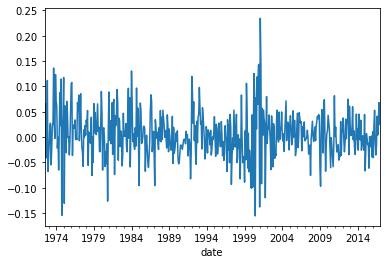

In [81]:
R_VmG=value_mktcapweighted[9].subtract(value_mktcapweighted[0])

(R_HmL).plot()
plt.show()

<AxesSubplot:xlabel='date'>

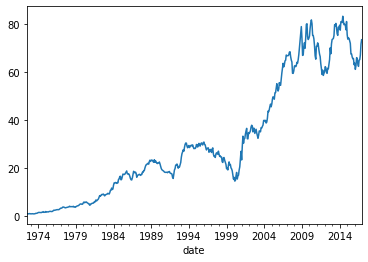

In [97]:

(R_HmL+rf+1).cumprod().plot()